In [1]:
import numpy as np 
import pandas as pd
from scipy.spatial.distance import hamming, jaccard, mahalanobis # inbuilt functions 
import matplotlib.pyplot as plt # for plotting

In [24]:
SEED = 13
np.random.seed(SEED) # set randomness to particular value instead of clock to get reproducible results

Please find the related comments and docstrings to find the working and explainations of the code. 
Put all the files in a single directory and for my ease, I hve renamed them as excel_0 and excel_1

# Q.1 
Entropy based supervised discretization method

In [78]:
df_raw = pd.read_excel('excel_0.xlsm') # import the data from excel file

In [79]:
df_raw.info() # see information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 15 columns):
Precipitation    2511 non-null float64
class            2511 non-null object
Unnamed: 2       0 non-null float64
min              7 non-null object
Unnamed: 4       11 non-null object
max              10 non-null object
Unnamed: 6       4 non-null float64
Unnamed: 7       0 non-null float64
Unnamed: 8       0 non-null float64
Cutoff           67 non-null float64
Entropy          67 non-null float64
a                67 non-null float64
p                67 non-null float64
D1               67 non-null float64
D2               67 non-null float64
dtypes: float64(11), object(4)
memory usage: 294.4+ KB


We have lots of missing values in the columns including Cutoff and Entropy 

In [80]:
df_raw.isna().sum() # get all the missing values in each column

Precipitation       0
class               0
Unnamed: 2       2511
min              2504
Unnamed: 4       2500
max              2501
Unnamed: 6       2507
Unnamed: 7       2511
Unnamed: 8       2511
Cutoff           2444
Entropy          2444
a                2444
p                2444
D1               2444
D2               2444
dtype: int64

We have 2444 values missing for most of the columns

In [81]:
df_raw.head() # show the first 5 rows of the data

,Precipitation,class,Unnamed: 2,min,Unnamed: 4,max,Unnamed: 6,Unnamed: 7,Unnamed: 8,Cutoff,Entropy,a,p,D1,D2
0,0.651808,a,NaN,0.171118,NaN,14.0226,NaN,NaN,NaN,0.271118,0.025804,0.001610,0.000000,0.025804,0.000000
1,0.515330,a,NaN,cutoff =,1,NaN,NaN,NaN,NaN,0.471118,0.025802,0.002013,0.000000,0.025802,0.000000
2,0.217331,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.671118,0.025787,0.005233,0.000000,0.025787,0.000000
3,0.676420,a,NaN,NaN,>=1,<1,NaN,NaN,NaN,0.871118,0.025784,0.020129,0.037037,0.024933,0.000851
4,0.171118,a,NaN,NaN,D1,D2,NaN,NaN,NaN,1.071118,0.025810,0.040660,0.037037,0.024838,0.000972


Data here is very messy. We just have to deal with the Entropy and Cutoff Scores for the first task so we can easily drop all the other columns of the dataset

In [87]:
df_raw.dropna(subset=['Cutoff','Entropy'],inplace=True) # drop rows where we do not have the values of Entropy and Cutoff

In [91]:
df_raw.shape

(67, 15)

There are just 67 rows in the dataset now

In [88]:
df = df_raw[['Cutoff','Entropy']] # get the columns from the data

There is a lot of missing data in the rows so we have to drop these

In [89]:
df.sample(5) # 5 random samples

,Cutoff,Entropy
24,5.071118,0.024672
50,10.271118,0.025796
42,8.671118,0.025408
38,7.871118,0.025558
16,3.471118,0.024676


In [40]:
min_ent_arr = df[df['Entropy']==df['Entropy'].min()].values  # get the row where Entropy in the dataset is minimum

In [42]:
df[df['Entropy']==df['Entropy'].min()]

,Cutoff,Entropy
32,6.671118,0.023266


Row number 32 has the minimum Entropy with Cutoff value of 6.67 and Entropy of 0.023

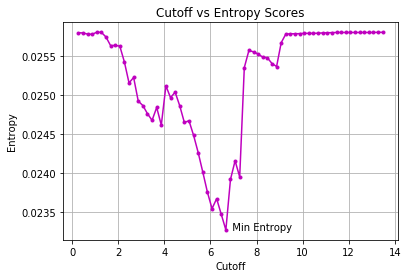

In [65]:
x,y = min_ent_arr[0][0],min_ent_arr[0,1]

plt.title('Cutoff vs Entropy Scores') # set title of figure
plt.plot(df['Cutoff'],df['Entropy'], marker='.',color='m') # plot line plot
plt.xlabel('Cutoff') 
plt.ylabel('Entropy')
plt.annotate(f'  Min Entropy', xy=(x,y)) # show where is the min entropy in figure
plt.grid()

We have almost fixed Entropy scores after the cutoff value around 9. Let us see if that score of 9 affects the other values too. 

Text(0, 0.5, 'A & P')

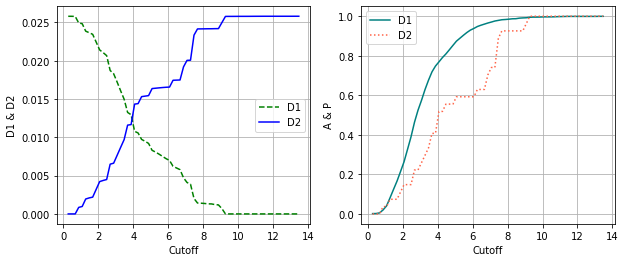

In [131]:
f,ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(df_raw['Cutoff'],df_raw['D1'],color='g',ls='--', label='D1')
ax[0].plot(df_raw['Cutoff'],df_raw['D2'],color='blue',label='D2')
ax[0].grid()
ax[0].legend()
ax[0].set_xlabel('Cutoff')
ax[0].set_ylabel('D1 & D2')

ax[1].plot(df_raw['Cutoff'],df_raw['a'],color='teal', label='D1')
ax[1].plot(df_raw['Cutoff'],df_raw['p'],color='tomato',label='D2', ls='dotted')
ax[1].grid()
ax[1].legend()
ax[1].set_xlabel('Cutoff')
ax[1].set_ylabel('A & P')

Our hypothesis was correct that at cutoff 9, every other attribute is hitting plateau

# Q.3

Mahalanobis distance is the distance between any data point and the Distribution. A datapoint is defined by the position vector in N-Dimensional Space. It overcomes the problems associated with other distance metrices. 

Mahalanobis distance is defined as

$$ 𝐷𝑀(x, 𝜇) = √︁(x − 𝜇)^𝑇 Σ^−1(x − 𝜇) $$


In [144]:
def mahalanobis(x):
    '''
    inp:
        X = vector X
        data: distribution in form numpy array
    out:
        distance of data from points
    '''
    new_x = x - np.mean(x) # subtrace data points from mean of each column
    cov = np.cov(x.values.T) # calculate covariane metric
    inv_covmat = np.linalg.inv(cov) # inverse covariance metric
    return np.dot(np.dot(new_x, inv_covmat), new_x.T).diagonal()

In [155]:
X = pd.DataFrame(np.random.randint(0,10,size=(6,3))) #generate random data

In [156]:
distances = mahalanobis(X) # distance of all of the data points from the Distribution

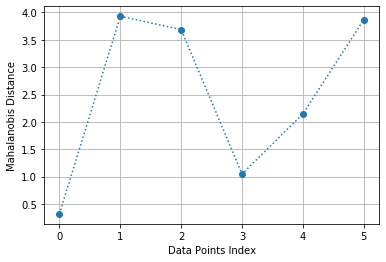

In [164]:
plt.plot(range(len(distances)),distances,marker='o',ls='dotted')
plt.xlabel('Data Points Index')
plt.ylabel('Mahalanobis Distance')
plt.grid()

# Q4
Hamming distance is the number of instances where two bits are different in a binary string but Jaccard Similarity is the proportion of the data where points share similarity

In [167]:
X = '010101001'
Y = '010010110'

In [168]:
X_bin = [int(i) for i in X]
Y_bin = [int(i) for i in Y] # converting to list of binary numbers

In [169]:
hamming(X_bin,Y_bin) # sklearn's library

0.6666666666666666

In [171]:
def hamm(X,Y):
    assert len(X)==len(Y) , "same number of elements must be there in both" # condition not met, throw exception
    count = 0
    for i in range(len(X)):
        if X[i]!=Y[i]:
            count+=1
    return count/len(X)

In [172]:
hamm(X,Y)

0.6666666666666666

In [173]:
from sklearn.metrics import jaccard_similarity_score

In [175]:
jaccard_similarity_score(X_bin,Y_bin)

0.3333333333333333

As we can see that Jaccard Similarity + Hamming Distance = 1, always